<div class="title">Introduction to Deep Neural Networks</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [2]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook).

In [5]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, load_sample_images, load_digits
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation

deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
from tensorflow import keras

import logging
import warnings
from sklearn.exceptions import ConvergenceWarning

from Utils import plot_dataset, plot_dataset_clas, plot_nonlinear_model_clas

matplotlib.rc("figure", figsize=(15, 5))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
seed = 123

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Vanishing Gradient

The following example illustrates the phenomenon of the vanishing gradient over a simple synthetic example.

## Model

The gradient of the MSE over a single pattern will be computed.
In particular, both the input $\mathbf{x}$ and the output $\mathbf{y}$ belong to $\mathbb{R}^5$.
Moreover, all the layers have $5$ hidden units, so the dimension of the weights between every pair of layer is a $5 \times 5$ matrix.
No bias are considered
The sigmoid activation function is used.

The weights are randomly intialized following a Gaussian.

In [6]:
n_dim = 5
n_lay = 50

np.random.seed(seed)

# Pattern.
x = np.random.randn(n_dim)
y = np.random.randn(n_dim)

# Activation function and its derivative.
g = lambda x: 1 / (1 + np.exp(-x))
gp = lambda x: g(x) * (1 - g(x))

# Weights.
w = np.random.randn(n_lay, n_dim, n_dim)

## Forward Phase

The following cell does the forward pass, computing the local field and output of each unit for the input pattern $\mathbf{x}$

In [7]:
o = np.zeros((n_dim, n_lay + 1))
a = np.zeros((n_dim, n_lay + 1))

o[:, 0] = x
for l in range(1, n_lay + 1):
    a[:, l] = w[l - 1, :, :] @ o[:, l - 1]
    o[:, l] = g(a[:, l])

<div class="qst">

* Does the previous code coincide with the algorithm studied in theory?

</div>

## Backward Phase

The following cell does the backward pass, computing first the error deltas, and then the partial derivative with respect to each weight.

In [8]:
d = np.zeros((n_dim, n_lay + 1))

d[:, -1] = (o[:, -1] - y) * gp(a[:, -1])
for l in range(n_lay, 0, -1):
    d[:, l - 1] = (w[l - 1, :, :] @ d[:, l]) * gp(a[:, l])

grad = np.zeros_like(w)
for l in range(n_lay):
    grad[l, :, :] = d[:, l, None] * o[:, None, l]

<div class="qst">

* Does the previous code coincide with the algorithm studied in theory?

</div>

## Comparative

This cell computes the norm of the gradient at each layer of the network, depicting it in logarithmic scale.

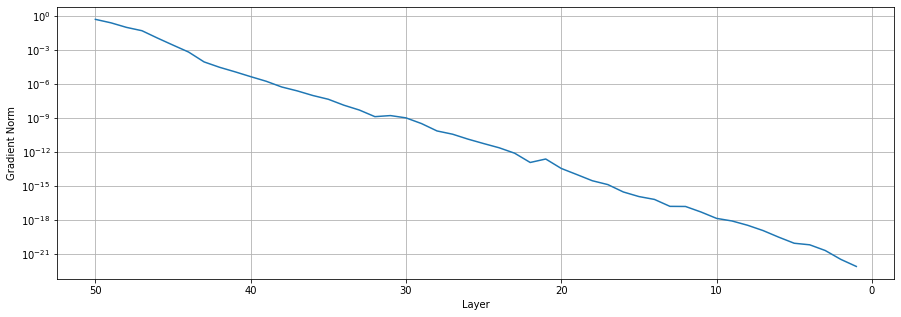

In [9]:
norms = np.zeros(n_lay)
for l in range(n_lay):
    norms[l] = np.linalg.norm(grad[l])

plt.semilogy(range(1, n_lay + 1), norms)
plt.grid()
plt.xlabel("Layer")
plt.ylabel("Gradient Norm")
plt.gca().invert_xaxis()
plt.show()

<div class="qst">

* According to the previous figure, how much slower is the training of the $30$-th layer than the training of the output layer?

</div>

# Initialization

The implementation of NNs of `sklearn` initializes the weights using the following uniform distribution:
$$ w^{(\ell)}_{ij} \sim  \mathcal{U} \left ( - \sqrt{\frac{6}{d_{\ell + 1} + d_\ell}}, + \sqrt{\frac{6}{d_{\ell + 1} + d_\ell}} \right ) . $$

## Model

The cell below creates a NN and trains it over a random dataset during only one iteration with an almost zero learning rate, so that the final weights are practically equal to the initial ones.

In [ ]:
n_pat = 10
n_dim = 5
layers = (20, 500, 100)

x = np.zeros((n_pat, n_dim))
y = np.zeros(n_pat)

model = MLPClassifier(
    hidden_layer_sizes=layers, max_iter=1, learning_rate_init=1e-50, random_state=seed
)
model = model.fit(x, y)

## Distribution of the Weights

This cell shows the distribution of the final weights for each layer.

In [ ]:
for l in range(len(layers) + 1):
    bound = np.sqrt(6.0 / (model.coefs_[l].shape[0] + model.coefs_[l].shape[1]))

    plt.hist(model.coefs_[l].ravel(), density=True, alpha=0.5)
    plt.scatter([-bound, bound], [0, 0], marker="|", s=2000, c="k")

    plt.title("Distribution of $\mathbf{W}^{(%d)}$" % l)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.show()

<div class="qst">

* Does the resultant empirical distribution match the theoretical one?

*Note*: The vertical black marks indicate the bounds of the uniform distribution defined above.

</div>

# Activation Functions

## Illustration

The following code depicts the activation functions available in `sklearn`, by building a NN with a single hidden unit and a linear output, so that the only transformation is precisely the activation function of the hidden unit.

In [ ]:
n_pat = 100
x = np.linspace(-3, 3, n_pat).reshape(-1, 1)
y = np.zeros(n_pat)

for activation in ("identity", "logistic", "tanh", "relu"):
    model = MLPRegressor(
        hidden_layer_sizes=(1,), activation=activation, max_iter=1, random_state=seed
    )
    model.fit(x, y)
    model.coefs_ = [np.array([[1]]), np.array([[1]])]
    model.intercepts_ = [np.array([0]), np.array([0])]

    plt.plot(x.ravel(), model.predict(x), label=activation)

plt.show()

<div class="qst">

* Can you distinguish the different activation functions?

</div>

## Comparative

The code below generates the 2-dimensional non-linear classification dataset of the two moons.

In [ ]:
n_pat = 200
noise = 0.15

np.random.seed(seed)

x, y = make_moons(n_samples=n_pat, noise=noise, random_state=seed)
y[y == 0] = -1
plot_dataset_clas(x, y)

The following cell trains four NNs with two hidden layers and $100$ hidden units in each layer, using the different activation functions.

In [ ]:
for activation in ("identity", "logistic", "tanh", "relu"):
    model = MLPClassifier(
        hidden_layer_sizes=(100, 100),
        activation=activation,
        max_iter=1000,
        random_state=seed,
    )
    model.fit(x, y)

    plot_nonlinear_model_clas(x, y, model, phi=lambda x: x)
    print("Activation: " + activation)
    plt.show()

<div class="qst">

* Which activation function works best?

</div>

# Data Augmentation

## Original Image

This cell loads a sample image from `sklearn` and shows it.

In [ ]:
china = load_sample_images().images[0]

plt.imshow(china)
plt.title("Original")
plt.axis("off")
plt.show()

## Random Perturbations

Random perturbations of a set of images can be generated using `keras`.
This is done using the previous sample image in the following code.

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

x = keras.preprocessing.image.img_to_array(china)
x = x.reshape((1,) + x.shape)

n_rows = 4
n_cols = 4
n_images = n_rows * n_cols

i = 0
plt.figure(figsize=(15, 15))
for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > n_images:
        break

    plt.subplot(n_rows, n_cols, i)
    plt.imshow(keras.preprocessing.image.array_to_img(batch[0]))
    plt.title("Sample %d" % i)
    plt.axis("off")

plt.tight_layout()
plt.show()

<div class="qst">

* Can you distinguish the different distorting effects?

</div>

# Transfer Learning

## Dataset

The following cell loads the simplified version of the MNIST dataset available in `sklearn`.
The dataset is modified to increase the size of the images to $80 \times 80$ (repeating the same pixel $10$ times along each axis) and adding colours (repeating the same value in the $3$ channels), so that it is compatible with sophisticated NN architectures.

After that, the dataset is divided into train and validation.

In [ ]:
x_orig, y = load_digits(n_class=10, return_X_y=True)

x = []
for img in x_orig:
    img = (
        img.reshape(8, 8)
        .repeat(10, axis=0)
        .repeat(10, axis=1)[:, :, None]
        .repeat(3, axis=2)
        .reshape(80, 80, 3)
    )
    img = img / 8 - 1
    x.append(img)
x_tr, x_va, y_tr, y_va = train_test_split(
    np.array(x), y, test_size=0.6, random_state=seed
)

## Initial Training

This cell creates a model based on a pretrained NN, adding a trainable dense layer at the end.

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(80, 80, 3),
    include_top=False,
)

base_model.trainable = False
inputs = keras.Input(shape=(80, 80, 3))
layers = base_model(inputs, training=False)
layers = keras.layers.GlobalAveragePooling2D()(layers)
layers = keras.layers.Dropout(0.2)(layers)
outputs = keras.layers.Dense(10, activation="softmax")(layers)
model = keras.Model(inputs, outputs)

model.summary()

<div class="qst">

* What percentage of the NN parameters will be modified?

</div>

The model can be now trained, while keeping frozen the pretrained layers.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

epochs = 5
history = model.fit(x_tr, y_tr, epochs=epochs, validation_data=(x_va, y_va))

<div class="qst">

* How does the model perform?

</div>

## Fine Tuning

In order to do the fine tuning, all the parameters are set as trainable.

In [ ]:
base_model.trainable = True
model.summary()

Now the model can be now trained, using a smaller learning rate.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

epochs = 2
history = model.fit(x_tr, y_tr, epochs=epochs, validation_data=(x_va, y_va))

<div class="qst">

* How does the model perform?
* Did the fine tuning improve the results?

</div>

# Dropout

The following code generates a simple regression problem using a parabola with noise.

In [ ]:
np.random.seed(seed)

n_pat = 64
lim = 3
noise = 1e0
x_orig = np.linspace(-lim, lim, n_pat)
x_long = np.linspace(-lim, lim, 10 * n_pat)
y = np.square(x_orig) + noise * np.random.randn(n_pat)
x = x_orig.reshape(-1, 1)

plot_dataset(x_orig, y)

Different NNs with two hidden layers and a dropout intermediate layer are trained and used to predict over this dataset.

In [ ]:
for d in (0.0, 0.2, 0.4, 0.6, 0.8):
    inputs = keras.Input(shape=(1))
    layers = keras.layers.Dense(100, activation="relu")(inputs)
    layers = keras.layers.Dropout(d)(layers)
    layers = keras.layers.Dense(100, activation="relu")(layers)
    outputs = keras.layers.Dense(1)(layers)
    model = keras.Model(inputs, outputs)
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        metrics=["mean_squared_error"],
    )

    epochs = 1000
    print("Fitting NN with dropout at %.0f%%" % (100 * d))
    model.fit(x, y, epochs=epochs, verbose=0)
    plt.plot(
        x_long, model.predict(x_long.reshape(-1, 1)), label="Dropout %.0f%%" % (100 * d)
    )

plt.plot(x_orig, y, "*k", label="Observed")
plt.legend()
plt.show()

<div class="qst">

* What is the effect of the dropout?
* Is it helping to prevent over-fitting?

</div>